# L&D Budget Analysis
This notebook explores the relationship between L&D spending and employee outcomes, including performance, satisfaction, and engagement.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [61]:
# load datasets
emp = pd.read_csv("Employee_Master.csv")
ld_spend_df = pd.read_csv("L_D_Spend.csv")
perf_scores = pd.read_csv("Performance_Scores.csv")
satisfaction = pd.read_csv("Satisfaction_and_Engagement.csv")

## Merge and Prep Data

In [62]:
emp_combined = emp.merge(ld_spend_df, on="emp_id")
emp_perf = perf_scores.pivot(index="emp_id", columns="quarter", values="performance").reset_index()
emp_perf.columns.name = None
emp_perf.columns = [str(col).upper() for col in emp_perf.columns]
emp_perf.rename(columns={"PERF_Q0": "Q0", "PERF_Q4": "Q4"}, inplace=True)
emp_perf["perf_change"] = emp_perf["Q4"] - emp_perf["Q0"]
emp_combined = emp_combined.merge(
    emp_perf[["EMP_ID", "Q0", "Q4", "perf_change"]],
    left_on="emp_id",
    right_on="EMP_ID"
)

## Exploratory Data Analysis

In [63]:
emp_combined.describe(include='all')

,emp_id,dept,level,gender,ethnicity,fte,hire_date,age_on_hire,tenure_yrs,status,ld_spend,EMP_ID,Q0,Q4,perf_change
count,500.000000,500,500,500,500,500.00000,500,500.00000,500.000000,500,500.000000,500.000000,500.000000,500.000000,500.000000
unique,NaN,5,4,3,6,NaN,428,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,HR,Mid,Female,Asian,NaN,2020-04-14,NaN,NaN,Active,NaN,NaN,NaN,NaN,NaN
freq,NaN,110,198,180,97,NaN,4,NaN,NaN,427,NaN,NaN,NaN,NaN,NaN
mean,250.500000,NaN,NaN,NaN,NaN,0.95640,NaN,40.18200,3.502700,NaN,357.740000,250.500000,70.477600,71.295573,0.817973
std,144.481833,NaN,NaN,NaN,NaN,0.08266,NaN,11.01888,1.157951,NaN,339.409915,144.481833,10.670929,10.878375,1.897168
min,1.000000,NaN,NaN,NaN,NaN,0.80000,NaN,21.00000,1.500000,NaN,0.000000,1.000000,33.000000,31.169417,-4.017121
25%,125.750000,NaN,NaN,NaN,NaN,1.00000,NaN,31.00000,2.560000,NaN,0.000000,125.750000,63.075000,64.086624,-0.435973
50%,250.500000,NaN,NaN,NaN,NaN,1.00000,NaN,40.00000,3.450000,NaN,280.000000,250.500000,70.800000,71.523073,0.831544
75%,375.250000,NaN,NaN,NaN,NaN,1.00000,NaN,50.00000,4.572500,NaN,680.000000,375.250000,77.900000,78.823775,2.111382


## Distribution of L&D Spend

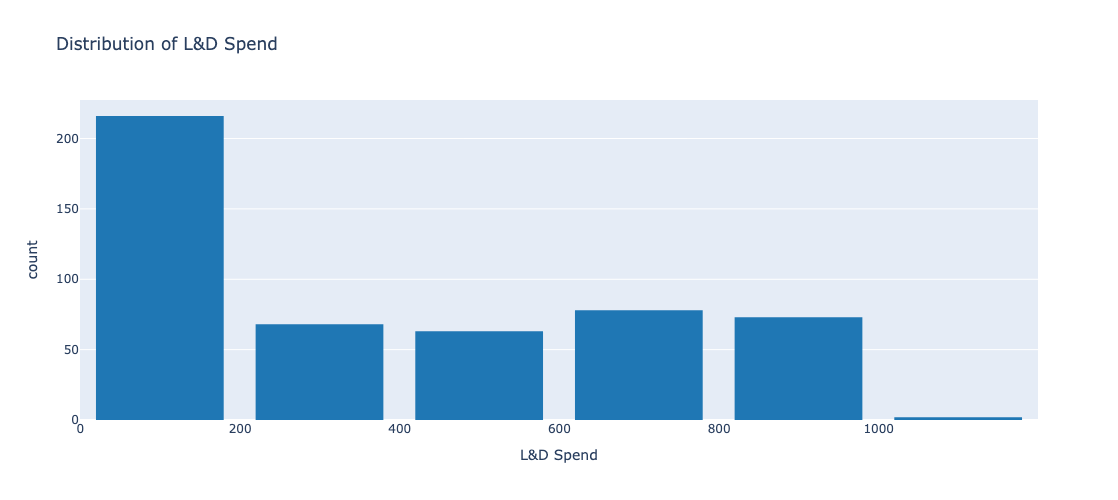

In [104]:
fig1 = px.histogram(
    emp_combined,
    x="ld_spend",
    nbins=10,
    title="Distribution of L&D Spend",
    labels={"ld_spend": "L&D Spend"},
    color_discrete_sequence=["#1f77b4"]
)
fig1.update_layout(bargap=0.2, height=500)
fig1.show()

## Correlation Matrix

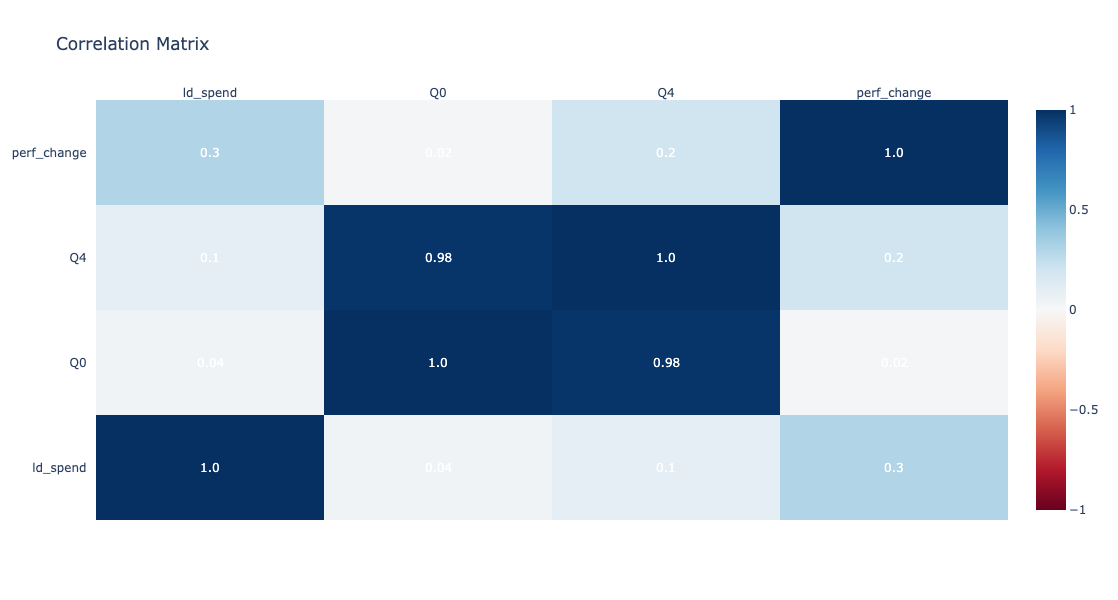

In [106]:
corr_data = emp_combined[["ld_spend", "Q0", "Q4", "perf_change"]].corr().round(2)
fig2 = ff.create_annotated_heatmap(
    z=corr_data.values,
    x=list(corr_data.columns),
    y=list(corr_data.index),
    colorscale='RdBu',
    showscale=True,
    zmin=-1, zmax=1
)
fig2.update_layout(title="Correlation Matrix", height=600)
fig2.show()

## Performance Change vs L&D Spend Tier

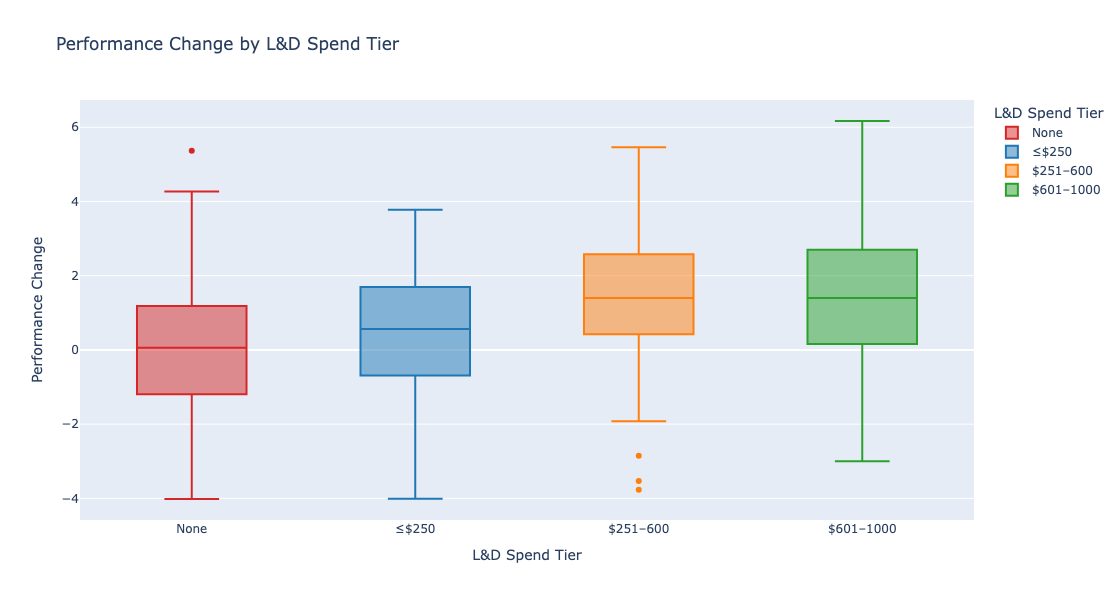

In [107]:
fig3_box = px.box(
    emp_combined,
    x="spend_tier",
    y="perf_change",
    category_orders={"spend_tier": ["None", "≤$250", "$251–600", "$601–1000"]},
    title="Performance Change by L&D Spend Tier",
    labels={"spend_tier": "L&D Spend Tier", "perf_change": "Performance Change"},
    color="spend_tier",
    color_discrete_map=tier_colors
)
fig3_box.update_layout(height=600)
fig3_box.show()

## Active Employees by Department and L&D Spend

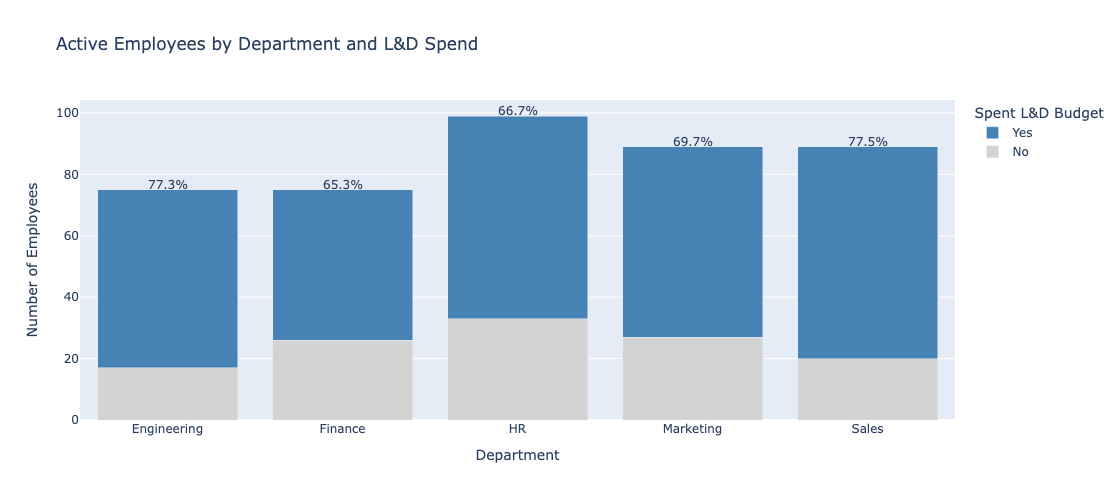

In [109]:
active_emps = emp_combined[emp_combined["status"] == "Active"].copy()
active_emps["spend_flag"] = active_emps["ld_spend"] > 0
dept_plot = active_emps.groupby(["dept", "spend_flag"]).size().unstack(fill_value=0)
dept_plot["total"] = dept_plot[True] + dept_plot[False]
dept_plot["yes_pct"] = (dept_plot[True] / dept_plot["total"] * 100).round(1)

import plotly.graph_objects as go

fig5 = go.Figure()
fig5.add_trace(go.Bar(name='No', x=dept_plot.index, y=dept_plot[False], marker_color='lightgray'))
fig5.add_trace(go.Bar(name='Yes', x=dept_plot.index, y=dept_plot[True], marker_color='steelblue'))

for i, dept in enumerate(dept_plot.index):
    fig5.add_annotation(x=dept, y=dept_plot.loc[dept, "total"] + 2, text=f"{dept_plot.loc[dept, 'yes_pct']}%", showarrow=False)

fig5.update_layout(
    barmode='stack',
    title='Active Employees by Department and L&D Spend',
    xaxis_title='Department',
    yaxis_title='Number of Employees',
    legend_title='Spent L&D Budget',
    height=500
)
fig5.show()

## Performance Change by Spend Tier and Department

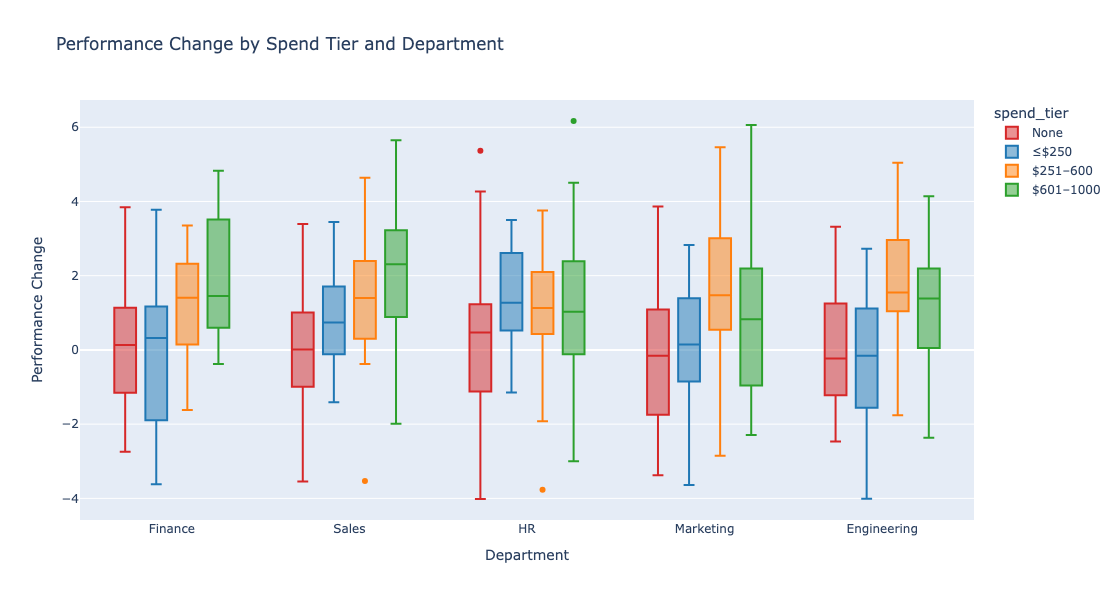

In [110]:
fig6_box = px.box(
    emp_combined,
    x="dept",
    y="perf_change",
    color="spend_tier",
    category_orders={"spend_tier": ["None", "≤$250", "$251–600", "$601–1000"]},
    title="Performance Change by Spend Tier and Department",
    labels={"perf_change": "Performance Change", "dept": "Department"},
    color_discrete_map=tier_colors
)
fig6_box.update_layout(height=600)
fig6_box.show()

## Performance Change by Spend Tier and Level

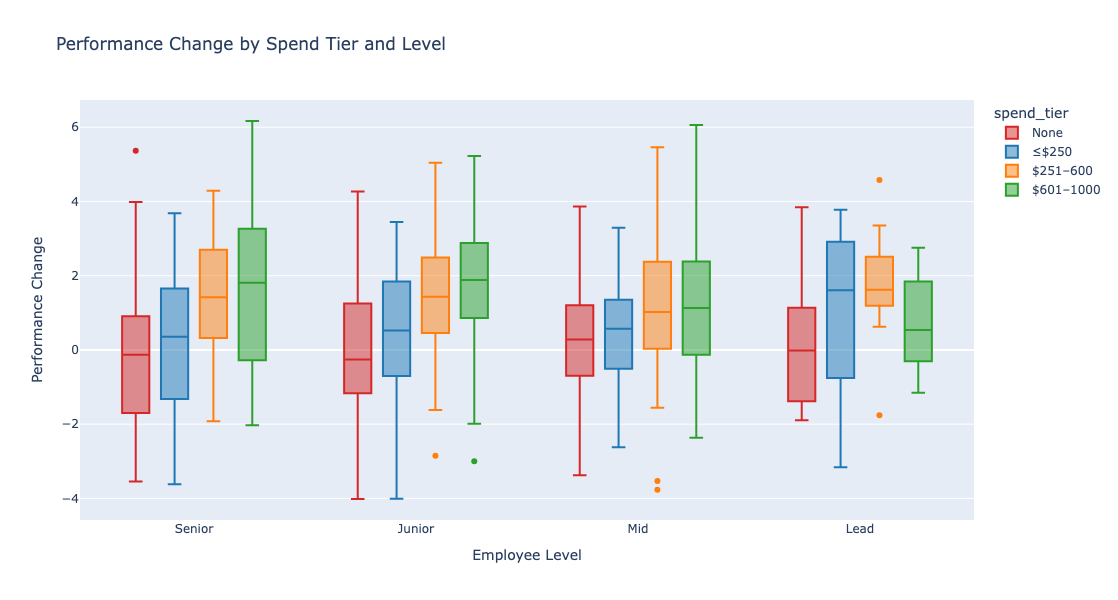

In [111]:
fig7_box = px.box(
    emp_combined,
    x="level",
    y="perf_change",
    color="spend_tier",
    category_orders={"spend_tier": ["None", "≤$250", "$251–600", "$601–1000"]},
    title="Performance Change by Spend Tier and Level",
    labels={"perf_change": "Performance Change", "level": "Employee Level"},
    color_discrete_map=tier_colors
)
fig7_box.update_layout(height=600)
fig7_box.show()

## Satisfaction Score at Q4 vs Spend Tier

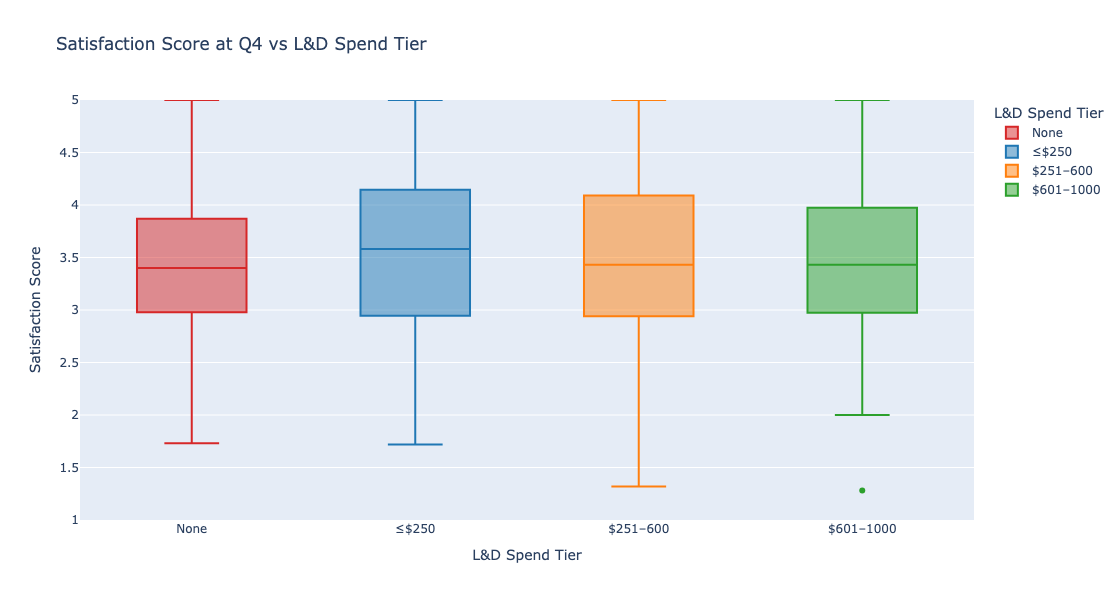

In [112]:
satisfaction_q4 = satisfaction[satisfaction["quarter"] == "Q4"].merge(ld_spend_df, on="emp_id")
satisfaction_q4["spend_tier"] = pd.cut(satisfaction_q4["ld_spend"], [-1, 0, 250, 600, 1000],
                                       labels=["None", "≤$250", "$251–600", "$601–1000"])

fig8 = px.box(
    satisfaction_q4,
    x="spend_tier",
    y="satisfaction_score",
    title="Satisfaction Score at Q4 vs L&D Spend Tier",
    labels={"spend_tier": "L&D Spend Tier", "satisfaction_score": "Satisfaction Score"},
    color="spend_tier",
    category_orders={"spend_tier": ["None", "≤$250", "$251–600", "$601–1000"]},
    color_discrete_map=tier_colors
)
fig8.update_yaxes(range=[1, 5])
fig8.update_layout(height=600)
fig8.show()

In [121]:
import statsmodels.formula.api as smf
from scipy import stats

# --- 1. OLS Regression: Does spending predict performance change? ---
model = smf.ols("perf_change ~ Q0 + ld_spend", data=emp_combined).fit()

# Get regression coefficient for L&D spend and p-value
ld_coef = model.params["ld_spend"]
ld_pval = model.pvalues["ld_spend"]

print(model.summary())

print("\nOutcome:")
if ld_pval < 0.05:
    print(f"L&D spending is positively associated with performance improvement (coef = {ld_coef:.3f}, p = {ld_pval:.4f}). This suggests that spending more on L&D may help improve employee performance.")
else:
    print(f"There is no statistically significant relationship between L&D spend and performance improvement (coef = {ld_coef:.3f}, p = {ld_pval:.4f}).")


                            OLS Regression Results                            
Dep. Variable:            perf_change   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     25.36
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           3.25e-11
Time:                        18:32:44   Log-Likelihood:                -1004.9
No. Observations:                 500   AIC:                             2016.
Df Residuals:                     497   BIC:                             2028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1070      0.545      0.196      0.8

In [122]:
# --- 2. Welch's t-test: Some Spend vs No Spend ---
spent   = emp_combined.loc[emp_combined["ld_spend"] > 0, "perf_change"]
nospend = emp_combined.loc[emp_combined["ld_spend"] == 0, "perf_change"]

t_stat, p_val = stats.ttest_ind(spent, nospend, equal_var=False)

print("\n=== T-Test ===")
print(f"T-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

print("\nOutcome")
if p_val < 0.05:
    print("Employees who spent some of their L&D budget showed significantly greater performance improvement compared to those who spent nothing (p < 0.05).")
else:
    print("There is no significant difference in performance improvement between employees who spent their L&D budget and those who didn’t (p > 0.05).")


=== T-Test ===
T-statistic = 6.05, p-value = 0.0000

Outcome
Employees who spent some of their L&D budget showed significantly greater performance improvement compared to those who spent nothing (p < 0.05).


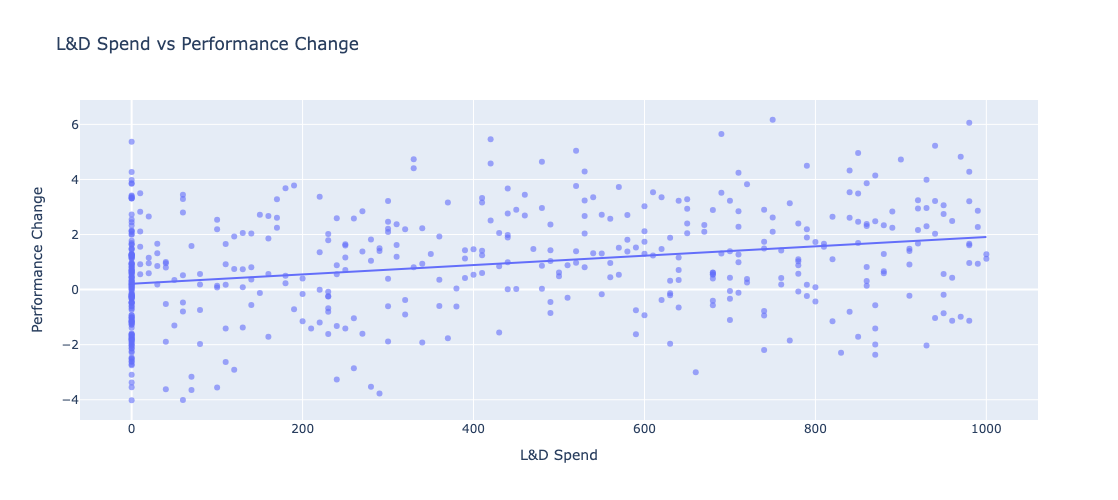

In [113]:
fig4 = px.scatter(
    emp_combined,
    x="ld_spend",
    y="perf_change",
    trendline="ols",
    title="L&D Spend vs Performance Change",
    labels={"ld_spend": "L&D Spend", "perf_change": "Performance Change"},
    opacity=0.6
)
fig4.update_layout(height=500)
fig4.show()